# Select practices prescibing nimodipine meeting eligibility criteria

## 1. Import all nimodipine data, filtering out closed and small practices

In [1]:

# Set dates of baseline and follow-up periods
d5 = '2019-03-01' # month after end of follow-up period
d4 = '2019-09-01' # follow-up start
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period


# first set up table to query
'''SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 '''

#### save as helen.nimodipine_20190513

# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM helen.nimodipine_20190513 a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22
1,C81110,04R,4,2017-05-01 00:00:00+00:00,10403,1,224
2,C84018,04K,4,2017-08-01 00:00:00+00:00,9453,1,30
3,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100
4,M83128,05W,4,2017-04-01 00:00:00+00:00,4273,1,72


## 2. Categorise date periods

In [2]:
### classify data by baseline period
import datetime

d3 = '2019-03-01' # month after end of baseline period
d2 = '2018-12-01' # start of 3-month baseline period
d1 = '2018-03-01' # start of 12-month baseline period

df1["12-mo-baseline"] = False
df1["3-mo-baseline"] = False
df1.loc[(df1['month']>=d1)&(df1['month']<d3), "12-mo-baseline"] = True
df1.loc[(df1['month']>=d2)&(df1['month']<d3), "3-mo-baseline"] = True

df1.head(10)

,practice,pct,setting,month,total_list_size,items,quantity,12-mo-baseline,3-mo-baseline
0,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22,True,False
1,C81110,04R,4,2017-05-01 00:00:00+00:00,10403,1,224,False,False
2,C84018,04K,4,2017-08-01 00:00:00+00:00,9453,1,30,False,False
3,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100,True,False
4,M83128,05W,4,2017-04-01 00:00:00+00:00,4273,1,72,False,False
5,E81036,06F,4,2019-01-01 00:00:00+00:00,13146,1,152,True,True
6,N81624,02F,4,2019-02-01 00:00:00+00:00,8230,1,112,True,True
7,M83691,05G,4,2018-11-01 00:00:00+00:00,1912,1,100,True,False
8,C86032,02X,4,2017-05-01 00:00:00+00:00,5805,1,336,False,False
9,D82008,06W,4,2017-04-01 00:00:00+00:00,12995,7,150,False,False


## 3. Group data and select practices meeting inclusion criteria for latest 3 and 12-month prescribing periods

In [3]:
### aggregate data over 6-month periods ( we will want to calculate the change between each)

# any prescribing in last 3 months
filter1 = df1.loc[df1["3-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()
filter1 = filter1.rename(columns={"items":"3-mo_items","quantity":"3-mo_quantity", "total_list_size":"3-mo_total_list_size"})

#sum over 12 months
agg = df1.loc[df1["12-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()

agg = agg.merge(filter1, on="practice", how="inner")#.groupby(["practice","3-mo-baseline"]).sum()
agg = agg.rename(columns={"items":"12-mo_items","quantity":"12-mo_quantity", "total_list_size":"12-mo_total_list_size"})

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo_items"]>1) | (agg["12-mo_quantity"]>56)]#.sort_values(by="quantity")
agg

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size
0,A82036,11,594,10106.750000,2,90,10191.000000
1,A83047,13,2812,14751.900000,5,1120,14805.333333
2,B82005,1,100,58595.000000,1,100,58595.000000
3,B86081,11,924,14308.909091,3,252,14355.666667
4,C81110,6,1344,10537.833333,1,224,10623.000000
5,C82027,8,224,7454.571429,1,28,7568.000000
6,C82051,12,672,11240.100000,4,224,11264.666667
7,C86007,11,1848,11831.200000,2,336,12146.000000
8,C87015,4,448,6998.666667,4,448,6998.666667
9,D82008,14,578,13473.875000,2,84,13597.500000


In [4]:
out = agg.copy()
out.to_csv('nimodipine_practices.csv') 

## Create histogram chart to demonstrate outlier status.

In [9]:
# import data for all practices

q = '''SELECT  
    pop.practice as practice,
    b.ccg_id as pct,
    setting,
    pop.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM `hscic.practice_statistics_all_years` pop 
   INNER JOIN hscic.practices b  ON b.code = pop.practice AND status_code = "A"
   LEFT JOIN helen.nimodipine_20190513 a ON a.practice = pop.practice AND a.month = pop.month
WHERE 
    pop.month BETWEEN '2018-12-01' and '2019-02-01' AND
    setting=4 AND
    pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df2 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

df2["month"] = pd.to_datetime(df2.month)

df2.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,E83018,07M,4,2019-02-01 00:00:00+00:00,16270,NaN,NaN
1,J82075,11A,4,2019-02-01 00:00:00+00:00,6927,NaN,NaN
2,G84005,07Q,4,2019-02-01 00:00:00+00:00,5189,NaN,NaN
3,N81624,02F,4,2019-02-01 00:00:00+00:00,8230,1.0,112.0
4,C82010,03W,4,2019-02-01 00:00:00+00:00,16138,NaN,NaN


In [10]:
df3 = df2.copy() 
data = df3.groupby("practice").sum().reset_index()
data["quantity_per_1000"] = 1000*data["quantity"]/data["total_list_size"]
data.head()

,practice,setting,total_list_size,items,quantity,quantity_per_1000
0,A81001,12,12256,0.0,0.0,0.0
1,A81002,12,58804,0.0,0.0,0.0
2,A81004,12,31889,0.0,0.0,0.0
3,A81005,12,24156,0.0,0.0,0.0
4,A81006,12,43777,0.0,0.0,0.0


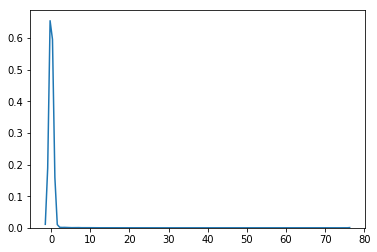

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.kdeplot(data["quantity_per_1000"], bw=0.5, legend=False)

plt.show()